# Real or Not? NLP with Disaster Tweets

https://www.kaggle.com/c/nlp-getting-started/overview

## Dataset overview

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train_dataset = pd.read_csv('train.csv')
test_dataset = pd.read_csv('test.csv')

print(f"Train shape: {train_dataset.shape}")
print(f"Test shape: {test_dataset.shape}")

Train shape: (7613, 5)
Test shape: (3263, 4)


In [3]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Look at an example of real and fake tweet

In [4]:
fake_tweets = train_dataset[train_dataset['target'] == 0]['text'].values
real_tweets = train_dataset[train_dataset['target'] == 1]['text'].values

print(f"Real tweet: {real_tweets[0]}")
print(f"Fake tweet: {fake_tweets[0]}")

Real tweet: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Fake tweet: What's up man?


In [5]:
train_dataset.duplicated().sum()

0

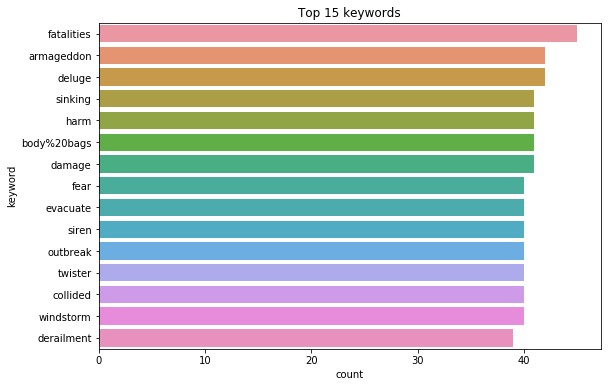

In [6]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_dataset.keyword, order = train_dataset.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

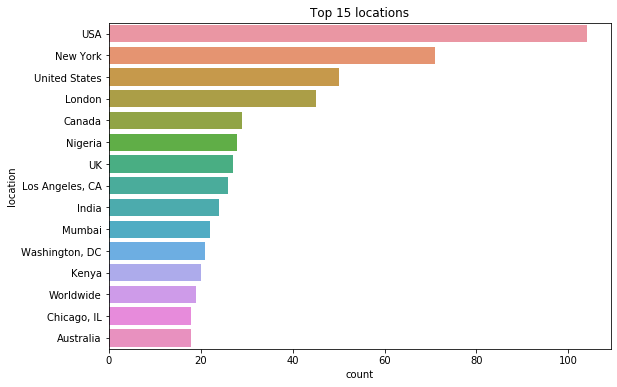

In [7]:
plt.figure(figsize=(9,6))
sns.countplot(y=train_dataset.location, order = train_dataset.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

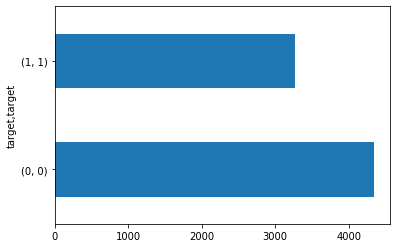

In [8]:
train_dataset.groupby('target').target.value_counts().plot.barh()

## Data Preprocessing

Избавляемся от мусора. Видим "London, UK" и "London". Непорядок. Пытаемся исправить.

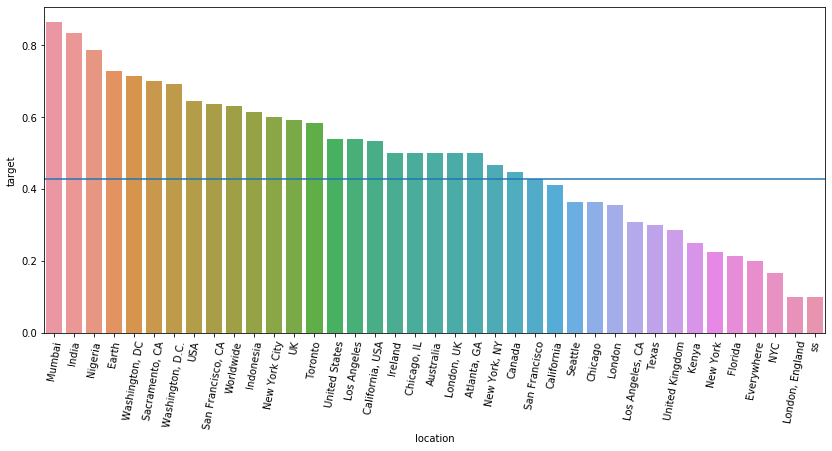

In [9]:
raw_loc = train_dataset.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train_dataset[train_dataset.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train_dataset.target))
plt.xticks(rotation=80)
plt.show()

In [10]:
# Fill NA values
for col in ['keyword','location']:
    train_dataset[col] = train_dataset[col].fillna('None')
    test_dataset[col] = test_dataset[col].fillna('None')

def clean_loc(x):
    if x == 'None':
        return 'None'
    elif x == 'Earth' or x =='Worldwide' or x == 'Everywhere':
        return 'World'
    elif 'New York' in x or 'NYC' in x:
        return 'New York'    
    elif 'London' in x:
        return 'London'
    elif 'Mumbai' in x:
        return 'Mumbai'
    elif 'Washington' in x and 'D' in x and 'C' in x:
        return 'Washington DC'
    elif 'San Francisco' in x:
        return 'San Francisco'
    elif 'Los Angeles' in x:
        return 'Los Angeles'
    elif 'Seattle' in x:
        return 'Seattle'
    elif 'Chicago' in x:
        return 'Chicago'
    elif 'Toronto' in x:
        return 'Toronto'
    elif 'Sacramento' in x:
        return 'Sacramento'
    elif 'Atlanta' in x:
        return 'Atlanta'
    elif 'California' in x:
        return 'California'
    elif 'Florida' in x:
        return 'Florida'
    elif 'Texas' in x:
        return 'Texas'
    elif 'United States' in x or 'USA' in x:
        return 'USA'
    elif 'United Kingdom' in x or 'UK' in x or 'Britain' in x:
        return 'UK'
    elif 'Canada' in x:
        return 'Canada'
    elif 'India' in x:
        return 'India'
    elif 'Kenya' in x:
        return 'Kenya'
    elif 'Nigeria' in x:
        return 'Nigeria'
    elif 'Australia' in x:
        return 'Australia'
    elif 'Indonesia' in x:
        return 'Indonesia'
    elif x in top_loc:
        return x
    else: return 'Others'
    
train_dataset['location_clean'] = train_dataset['location'].apply(lambda x: clean_loc(str(x)))
test_dataset['location_clean'] = test_dataset['location'].apply(lambda x: clean_loc(str(x)))

Смотрим еще раз. Все в порядке. Хотя что такое "ss" все равно непонятно.

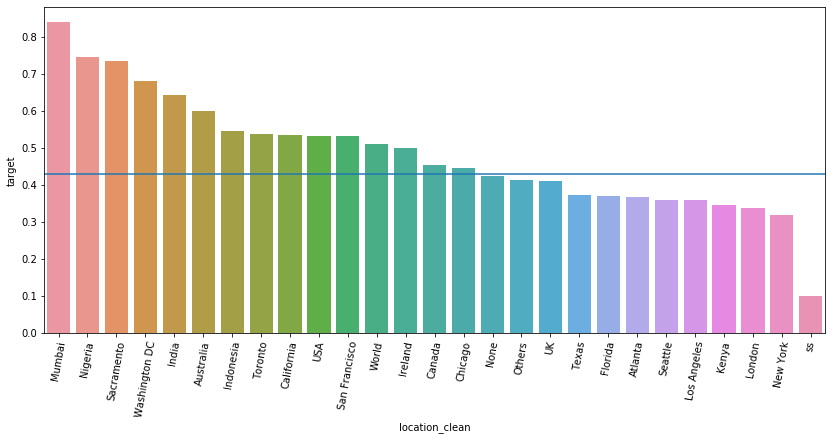

In [11]:
top_l2 = train_dataset.groupby('location_clean').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l2.index, y=top_l2)
plt.axhline(np.mean(train_dataset.target))
plt.xticks(rotation=80)
plt.show()

Чистим текст: удаляем ссылки, \n, и пустые пробелы

In [12]:
import re

test_str = train_dataset.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [13]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    
    return df
    
train_dataset = process_text(train_dataset)
test_dataset = process_text(test_dataset)

## Dataset preparation

In [14]:
SEED = 42

In [15]:
from sklearn.model_selection import train_test_split

tweets = train_dataset['text'].values
targets = train_dataset['target'].values

X_train, X_val, y_train, y_val = train_test_split(tweets, targets, test_size=0.2, random_state = SEED)

test_tweets = test_dataset['text'].values

In [16]:
import tensorflow as tf

np.random.seed(SEED)
tf.random.set_seed(SEED)

### DistilBert model
https://huggingface.co/transformers/model_doc/distilbert.html

In [28]:
import transformers
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [29]:
import tqdm

MAX_SEQ_LENGTH = 500

def create_input_features(tokenizer, docs, max_seq_length):
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        tokens = tokenizer.tokenize(doc)
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
        all_ids.append(ids)
        all_masks.append(masks)
    encoded = np.array([all_ids, all_masks])
    return encoded

In [32]:
def build_model():
    inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
    inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
    inputs = [inp_id, inp_mask]

    hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
    pooled_output = hidden_state[:, 0]
    
    dense1 = tf.keras.layers.Dense(128, activation='relu')(pooled_output)
    drop1 = tf.keras.layers.Dropout(0.3)(dense1)
    
#     dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
#     drop2 = tf.keras.layers.Dropout(0.3)(dense2)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(drop1)

    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08), 
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [33]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
bert_input_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
bert_input_masks (InputLayer)   [(None, 500)]        0                                            
__________________________________________________________________________________________________
tf_distil_bert_model_2 (TFDisti ((None, 500, 768),)  66362880    bert_input_ids[0][0]             
                                                                 bert_input_masks[0][0]           
__________________________________________________________________________________________________
tf_op_layer_strided_slice_2 (Te [(None, 768)]        0           tf_distil_bert_model_2[0][0

66,625,793 параметров??!!! Чтобы генерировать правдоподобные ЭКГ понадобилось всего 474,097 (gen) + 714,721 (disc) = 1,188,818

In [34]:
train_features_ids, train_features_masks = create_input_features(tokenizer, X_train, max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_input_features(tokenizer, X_val,max_seq_length=MAX_SEQ_LENGTH)

Converting docs to features: 100%|██████████| 1523/1523 [00:01<00:00, 1138.03it/s]


In [35]:
print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)

Train Features: (6090, 500) (6090, 500)
Val Features: (1523, 500) (1523, 500)


## Training

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model.fit(
    [train_features_ids, train_features_masks], 
    y_train, 
    validation_data=([val_features_ids, val_features_masks], y_val),
    epochs=5, 
    batch_size=9,
    callbacks=[early_stop],
    shuffle=True,
    verbose=1
)

Epoch 1/5
677/677 [==============================] - 409s 604ms/step - loss: 0.4402 - accuracy: 0.8072 - val_loss: 0.3870 - val_accuracy: 0.8411
Epoch 2/5
677/677 [==============================] - 407s 602ms/step - loss: 0.3191 - accuracy: 0.8693 - val_loss: 0.3843 - val_accuracy: 0.8457
Epoch 3/5
346/677 [==============>...............] - ETA: 3:04 - loss: 0.2288 - accuracy: 0.9127

## Testing

In [24]:
test_features_ids, test_features_masks = create_input_features(tokenizer,test_tweets,max_seq_length=MAX_SEQ_LENGTH)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 3263/3263 [00:02<00:00, 1125.20it/s]

Test Features: (3263, 500) (3263, 500)


In [25]:
raw_predictions = model.predict([test_features_ids, test_features_masks]).ravel()

In [26]:
threshold = 0.55

predictions = [1 if prediction > threshold else 0 for prediction in raw_predictions]

In [27]:
ids = test_dataset['id']
result = pd.DataFrame(list(zip(ids, predictions)), columns=['id', 'target'])
result.to_csv('submission_preproc.csv', index=False)